In [295]:
from opt.mc_sim import *
import time
from common.variables import *

In [296]:
import pickle as pkl
from opt.eval_policy import *

# filename = "output/msource_value_dic_06-16-2022-09-56-03.pkl"
filename = "output/msource_value_dic_06-21-2022-15-52-26.pkl"

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]
sourcingEnv = output_obj["mdp_env"]

In [297]:
model_params

{'algo_params': {'prob_epsilon': 1e-08,
  'periods': 3,
  'nested_mc_iters': 2,
  'mc_episodes': 3,
  'max_steps': 3,
  'explore_eps': 0.05,
  'debug_bool': 0,
  'fixed_learn_rate': 0.2},
 'policy_params': {'h_cost': 2,
  'b_penalty': 7,
  'small_s': 2,
  'big_s': 15,
  'n_suppliers': 2,
  'backorder_max': -10,
  'inven_limit': 30},
 'mdp_env_params': {'lambda': 9,
  'max_inven': 30,
  'action_size': 4,
  'discount_fac': 1.0}}

In [298]:
# sourcingEnv = SourcingEnv(
#         lambda_arrival = 8, # or 10
#         procurement_cost_vec = np.array([3, 1, 2]),
#         supplier_lead_times_vec = np.array([0.8, 0.5, 1.0]),
#         on_times = np.array([1, 1, 2]), 
#         off_times = np.array([0.3, 1, 0.2]))

# Dual Sourcing
# sourcingEnv = SourcingEnv(
#         lambda_arrival = LAMBDA, # or 10
#         procurement_cost_vec = np.array([3, 1]),
#         supplier_lead_times_vec = np.array([0.8, 0.5]),
#         on_times = np.array([1, 1]), 
#         off_times = np.array([0.3, 1]))

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

mc_avg_costs = mc_with_ss_policy(sourcingEnv, start_state = s_custom, 
    periods = 30,
    nested_mc_iters = 50,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'])

# print(mc_avg_costs)

In [299]:
print(s_custom)

Stock: 0, n backorders: [0 0], supplier status (on/off): [1 1]


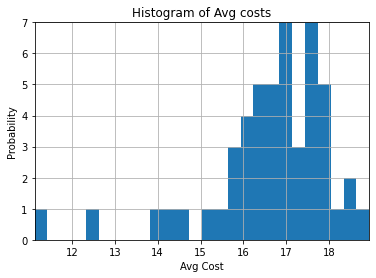

In [300]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 0.3
n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs), np.max(mc_avg_costs) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [301]:
print(np.mean(np.array(mc_avg_costs)))

16.62333333333333


In [302]:
np.std(np.array(mc_avg_costs))

1.4213178548250365

In [303]:
print(sourcingEnv.reset())

Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]


In [304]:
repr(str(sourcingEnv.reset()))

"'Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]'"

In [305]:
model_params

{'algo_params': {'prob_epsilon': 1e-08,
  'periods': 3,
  'nested_mc_iters': 2,
  'mc_episodes': 3,
  'max_steps': 3,
  'explore_eps': 0.05,
  'debug_bool': 0,
  'fixed_learn_rate': 0.2},
 'policy_params': {'h_cost': 2,
  'b_penalty': 7,
  'small_s': 2,
  'big_s': 15,
  'n_suppliers': 2,
  'backorder_max': -10,
  'inven_limit': 30},
 'mdp_env_params': {'lambda': 9,
  'max_inven': 30,
  'action_size': 4,
  'discount_fac': 1.0}}

In [306]:
# try a bit of indifference rounding
# for k in value_dic.keys():
#     value_dic[k] = round(value_dic[k], 3)


In [307]:
eval_steps = 30
mc_eval_iter = 50
eval_costs = mc_eval_policy_from_value_dic(sourcingEnv, value_dic, 
    max_steps = eval_steps, mc_iters = mc_eval_iter)

avg_eval_cost = np.mean(eval_costs)

MC eval iter: 0
MC eval iter: 1
MC eval iter: 2
MC eval iter: 3
MC eval iter: 4
MC eval iter: 5
MC eval iter: 6
MC eval iter: 7
MC eval iter: 8
MC eval iter: 9
MC eval iter: 10
MC eval iter: 11
MC eval iter: 12
MC eval iter: 13
MC eval iter: 14
MC eval iter: 15
MC eval iter: 16
MC eval iter: 17
MC eval iter: 18
MC eval iter: 19
MC eval iter: 20
MC eval iter: 21
MC eval iter: 22
MC eval iter: 23
MC eval iter: 24
MC eval iter: 25
MC eval iter: 26
MC eval iter: 27
MC eval iter: 28
MC eval iter: 29
MC eval iter: 30
MC eval iter: 31
MC eval iter: 32
MC eval iter: 33
MC eval iter: 34
MC eval iter: 35
MC eval iter: 36
MC eval iter: 37
MC eval iter: 38
MC eval iter: 39
MC eval iter: 40
MC eval iter: 41
MC eval iter: 42
MC eval iter: 43
MC eval iter: 44
MC eval iter: 45
MC eval iter: 46
MC eval iter: 47
MC eval iter: 48
MC eval iter: 49


In [308]:
eval_costs_scaled = np.array(eval_costs)/eval_steps

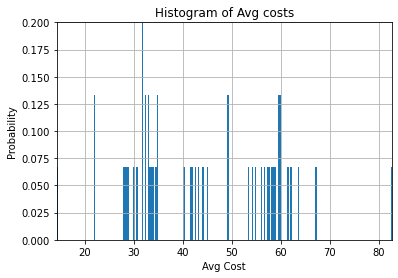

In [309]:
import numpy as np

binwidth = 0.3

n, bins, patches = plt.hist(eval_costs_scaled, bins=np.arange(min(eval_costs_scaled), max(eval_costs_scaled) + binwidth, binwidth), density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(eval_costs_scaled), np.max(eval_costs_scaled))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [310]:
np.mean(eval_costs_scaled)

44.047333333333334

In [311]:
np.std(eval_costs_scaled)

14.51752517935937

In [312]:
len(list(value_dic.keys()))

16539

-3.666666666666667

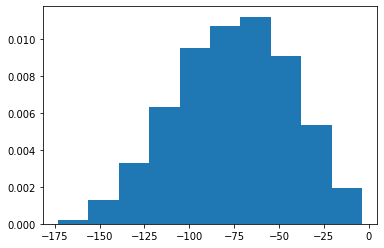

In [313]:
import numpy as np

binwidth = 0.3

state_vals = list(value_dic.values())

n, bins, patches = plt.hist(state_vals, density = True)
np.max(state_vals)

In [314]:
len(set(state_vals))

1887

In [315]:
len(state_vals)

16539

In [316]:
state_vals

[-23.666666666666668,
 -19.666666666666664,
 -13.166666666666666,
 -25.666666666666668,
 -15.666666666666668,
 -11.333333333333332,
 -11.833333333333332,
 -17.333333333333332,
 -19.833333333333332,
 -21.0,
 -17.166666666666668,
 -18.333333333333332,
 -20.8,
 -21.333333333333332,
 -11.0,
 -24.166666666666664,
 -14.333333333333334,
 -14.833333333333334,
 -10.333333333333332,
 -21.333333333333332,
 -20.166666666666664,
 -21.333333333333332,
 -19.666666666666668,
 -21.333333333333336,
 -23.333333333333332,
 -20.666666666666664,
 -16.333333333333336,
 -22.333333333333336,
 -23.166666666666668,
 -16.933333333333334,
 -12.166666666666668,
 -23.666666666666664,
 -16.666666666666664,
 -22.833333333333336,
 -16.5,
 -18.166666666666668,
 -20.666666666666668,
 -19.0,
 -15.306666666666667,
 -24.0,
 -21.6,
 -21.833333333333332,
 -24.0,
 -25.333333333333332,
 -25.0,
 -19.833333333333332,
 -14.5,
 -22.333333333333332,
 -24.0,
 -22.5,
 -15.666666666666668,
 -29.666666666666668,
 -25.0,
 -24.66666666666

In [317]:

max(value_dic, key=value_dic.get)


'[0, 5, 0, 0, 1]'

In [318]:
min(value_dic, key=value_dic.get)

'[17, 29, 45, 1, 1]'

In [319]:
value_dic_key_sorted = sorted(value_dic, key=value_dic.get, reverse=True)
value_dic_value_sorted = sorted(value_dic.values(), reverse=True)

In [320]:
value_diagnostic = list(zip(value_dic_key_sorted, value_dic_value_sorted))

In [321]:
value_diagnostic

[('[0, 5, 0, 0, 1]', -3.666666666666667),
 ('[0, 7, 2, 1, 1]', -4.333333333333334),
 ('[0, 14, 1, 0, 1]', -5.333333333333333),
 ('[0, 9, 1, 0, 1]', -5.5),
 ('[0, 1, 2, 0, 1]', -6.333333333333333),
 ('[0, 7, 0, 1, 1]', -6.666666666666666),
 ('[0, 4, 2, 1, 0]', -6.833333333333333),
 ('[0, 8, 2, 0, 1]', -6.833333333333333),
 ('[0, 3, 4, 1, 1]', -8.0),
 ('[0, 9, 5, 1, 1]', -8.333333333333332),
 ('[0, 4, 5, 1, 0]', -8.5),
 ('[1, 13, 1, 1, 1]', -8.5),
 ('[0, 4, 3, 1, 1]', -8.666666666666668),
 ('[0, 13, 3, 1, 1]', -8.833333333333332),
 ('[0, 1, 7, 1, 1]', -9.0),
 ('[0, 5, 2, 0, 1]', -9.0),
 ('[0, 4, 7, 1, 0]', -9.166666666666666),
 ('[0, 4, 1, 1, 0]', -9.166666666666668),
 ('[0, 5, 1, 0, 1]', -9.166666666666668),
 ('[0, 7, 0, 0, 1]', -9.333333333333332),
 ('[0, 11, 0, 0, 1]', -9.333333333333334),
 ('[0, 3, 2, 1, 1]', -9.666666666666666),
 ('[0, 7, 4, 0, 1]', -9.666666666666668),
 ('[0, 2, 3, 1, 0]', -9.833333333333332),
 ('[0, 9, 5, 1, 0]', -9.833333333333332),
 ('[0, 3, 3, 1, 0]', -10.16666

In [322]:
with open('output/diagnostic_output.txt', 'w') as f:
    for item in value_diagnostic:
        f.write("{i}\n".format(i = str(item)) )

In [323]:
item

('[17, 29, 45, 1, 1]', -173.33333333333334)